In [0]:
from tensorflow.python.keras.datasets import mnist
from tensorflow.python.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.python.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras.layers.convolutional import UpSampling2D, Conv2D, MaxPooling2D, Conv2DTranspose
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

from tqdm import tqdm, tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt

import glob
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow

In [0]:
def sample_images(epoch, latent_dim, generator):
    r, c = 5, 5
    # generate image from noise
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    # rescale images 0..1
    gen_imgs = 0.5 * gen_imgs + 0.5

    print('img_shape: ', gen_imgs.shape)
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
      for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt, :,:,0])
        axs[i,j].axis('off')
        cnt += 1
    plt.show()
    plt.close()

### Load dataset, define DataLoader

In [0]:
# define constants (hard code)/ hyper parameters
BATCH_SIZE = 128
TRAIN_SIZE = 50000
VAL_SIZE = 10000
IMG_SIZE = 28
LATENT_DIM = 100
EPOCHS = 20000

### Define and train GAN
link: 
- https://github.com/eriklindernoren/Keras-GAN/blob/master/dcgan/dcgan.py
- https://github.com/GANs-in-Action/gans-in-action/blob/master/chapter-4/Chapter_4_DCGAN.ipynb


### Generator

In [0]:
def build_generator(z_dim):
    model = Sequential()

    # reshape input to 7x7x256 tensor via dense layer
    model.add(Dense(256*7*7, input_dim=z_dim))
    model.add(Reshape((7,7,256)))
    
    # transposed convolution, from 7,7,256 to 14,14,128 (instead of max pool upsampling)
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')) 
    #model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    # transposed convolution, from 14,14,128 to 14,14,64 (instead of max pool upsampling)
    model.add(Conv2DTranspose(128, kernel_size=3, strides=1, padding='same'))
    #model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    # transposed convolution, from 14,14,64 to 28,28,1 (instead of max pool upsampling)
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))

    model.add(Activation('tanh'))
    
    print(model.summary())
    return model

### Discriminator

In [0]:
def build_discriminator(img_shape):
    model = Sequential()

    # convolution from 28,28,1 to 14,14,32
    model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', input_shape=img_shape))
    model.add(LeakyReLU(alpha=0.01))
    
    # convolution from 14,14,32 to 7,7,64
    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same'))
    #model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    # convolution from 7,7,64 to 3,3,128
    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    #model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    print(model.summary())
    return model

### Build model

In [0]:
def build_gan(generator, discriminator):
  model = Sequential()

  # combined generator - discriminator
  model.add(generator)
  model.add(discriminator)
  return model

In [8]:
#optimizer = Adam()

# build and compile discriminator
discriminator = build_discriminator(img_shape=(IMG_SIZE, IMG_SIZE,1))
discriminator.compile(loss='binary_crossentropy',
                            optimizer=Adam(learning_rate=1e-4, clipvalue=1.0, decay=1e-8),
                            metrics=['accuracy'])

# build generator
generator = build_generator(z_dim=LATENT_DIM)

# for compined model we will only train generator
# freeze discriminator weights, when we train G, D is not training
# keep discriminator's parameters constant for generator training
discriminator.trainable = False

# build and compile GAN model with fixed discriminator
gan = build_gan(generator, discriminator)
gan.compile(loss = 'binary_crossentropy', optimizer=Adam(learning_rate=0.0002, clipvalue=1.0, decay=1e-8))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 4, 4, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0

In [11]:
gan.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 28, 28, 1)         1710721   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 94721     
Total params: 1,805,442
Trainable params: 1,710,721
Non-trainable params: 94,721
_________________________________________________________________


### Training

In [0]:
def train(epochs, latent_dim, batch_size, sample_interval=100):
  # load mnist dataset
  (X_train, _), (_, _) = mnist.load_data()

  # rescale -1 to 1
  X_train = X_train / 127.5 - 1
  # exapnd dimension
  X_train = np.expand_dims(X_train, axis=3)

  # batch of ground truth / fake labels
  # labels for real images: all ones
  valid = np.ones((batch_size, 1))
  # labels for fake images: all zeros
  fake = np.zeros((batch_size, 1))

  start = 0
  for epoch in range(epochs):
    # ---------------------
    #  Train Discriminator
    # ---------------------
    # select random batch of images
    idx = np.random.randint(0, X_train.shape[0], batch_size) # generate random indexes to extract from X_train
    #imgs = X_train[idx]
    #print('check shapes: ', imgs.shape, X_train.shape, idx)

    # generate random batch of fake imgs by generator
    # generate noise for generator input
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    gen_imgs = generator.predict(noise)

    # combine real/ fake imgs
    stop = start + batch_size
    real_imgs = X_train[start:stop]
    combined_imgs = np.concatenate([gen_imgs, real_imgs])

    # assemble labels discriminating ral/ fake imgs
    labels = np.concatenate([fake, valid])
    # add random noise to the labels - important trick !!!
    labels += 0.05 * np.random.random(labels.shape)

    # train discriminator
    d_loss = discriminator.train_on_batch(combined_imgs, labels)
    #d_loss_real = discriminator.train_on_batch(imgs, valid) # real imgs and 1 labels
    #d_loss_fake = discriminator.train_on_batch(gen_imgs, fake) # fake imgs from G and 0 labels
    # sum losses from train discriminator
    #d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  Train Generator
    # ---------------------
    # generate random batch of fake imgs by generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    # train generator (to have discriminator label samples as valid). train combined model 
    g_loss = gan.train_on_batch(noise, valid)

    # at save interval save generated image samples, make summary
    if epoch % sample_interval == 0:
      # plot progress
      print('%d [D loss: %f, acc.: %.2f%%] [G loss: %f]' % (epoch, d_loss[0], 100*d_loss[1], g_loss))
      # output a sample of generated images
      sample_images(epoch, latent_dim, generator)

In [0]:
# generator trainable params are held const during discriminator training and vice versa
train(epochs=EPOCHS, latent_dim=LATENT_DIM, batch_size=BATCH_SIZE)

### OK reference, keep it for comparison
- GANs in action architecture + params
- different lr, optimizers for D,G
- random noise to labels added
- no batchnorm

In [10]:
# generator trainable params are held const during discriminator training and vice versa
train(epochs=EPOCHS, latent_dim=LATENT_DIM, batch_size=BATCH_SIZE)

Output hidden; open in https://colab.research.google.com to view.

### Keep for comparison

In [51]:
train(epochs=20000, batch_size=128, sample_interval=100)

Output hidden; open in https://colab.research.google.com to view.

----------------------------
### Reference solution


In [0]:
img_rows = 28
img_cols = 28
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100

In [0]:
def build_generator(z_dim):

    model = Sequential()

    # Reshape input into 7x7x256 tensor via a fully connected layer
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))

    # Transposed convolution layer, from 7x7x256 into 14x14x128 tensor
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Transposed convolution layer, from 14x14x128 to 14x14x64 tensor
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Transposed convolution layer, from 14x14x64 to 28x28x1 tensor
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))

    # Output layer with tanh activation
    model.add(Activation('tanh'))

    return model

In [0]:
def build_discriminator(img_shape):

    model = Sequential()

    # Convolutional layer, from 28x28x1 into 14x14x32 tensor
    model.add(
        Conv2D(32,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer, from 14x14x32 into 7x7x64 tensor
    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer, from 7x7x64 tensor into 3x3x128 tensor
    model.add(
        Conv2D(128,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Output layer with sigmoid activation
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [0]:
def build_gan(generator, discriminator):

    model = Sequential()

    # Combined Generator -> Discriminator model
    model.add(generator)
    model.add(discriminator)

    return model

In [0]:
# Build and compile the Discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

# Build the Generator
generator = build_generator(z_dim)

# Keep Discriminator’s parameters constant for Generator training
discriminator.trainable = False

# Build and compile GAN model with fixed Discriminator to train the Generator
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [0]:
losses = []
accuracies = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval):

    # Load the MNIST dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale [0, 255] grayscale pixel values to [-1, 1]
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    # Labels for real images: all ones
    real = np.ones((batch_size, 1))

    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Get a random batch of real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Discriminator
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # Train Generator
        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:

            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            # Output a sample of generated image
            sample_images(generator)

In [0]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Generate images from random noise
    gen_imgs = generator.predict(z)

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()
    plt.close()

100 [D loss: 0.002398, acc.: 100.00%] [G loss: 1.276991]


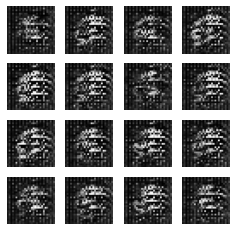

200 [D loss: 0.000379, acc.: 100.00%] [G loss: 0.246239]


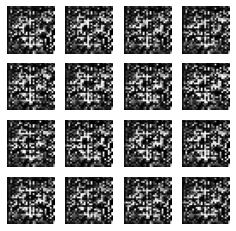

300 [D loss: 0.000073, acc.: 100.00%] [G loss: 0.022386]


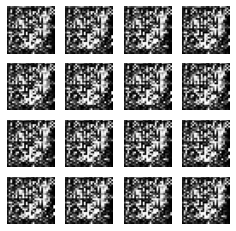

400 [D loss: 0.000032, acc.: 100.00%] [G loss: 0.002546]


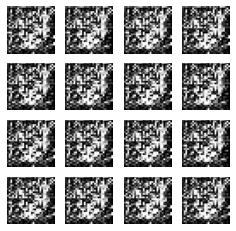

500 [D loss: 0.000012, acc.: 100.00%] [G loss: 0.001674]


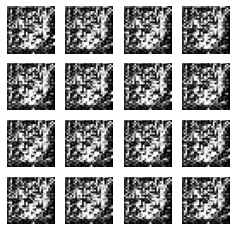

600 [D loss: 0.000009, acc.: 100.00%] [G loss: 0.001292]


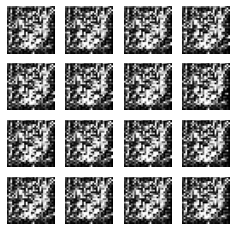

700 [D loss: 0.000006, acc.: 100.00%] [G loss: 0.000902]


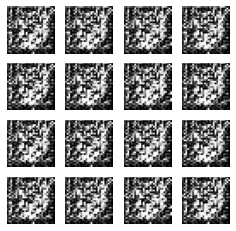

800 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.000756]


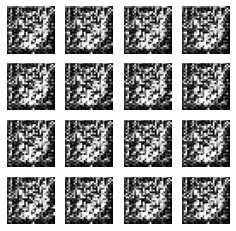

900 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.000625]


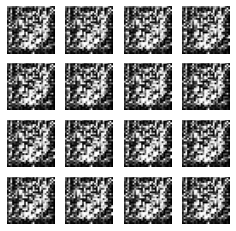

1000 [D loss: 0.000004, acc.: 100.00%] [G loss: 0.000554]


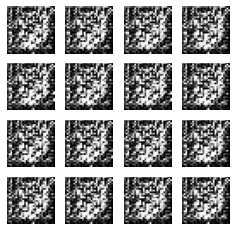

1100 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.000498]


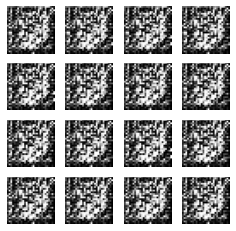

1200 [D loss: 0.000002, acc.: 100.00%] [G loss: 0.000469]


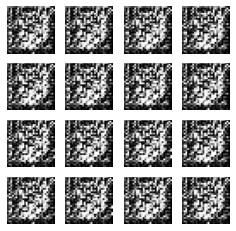

1300 [D loss: 0.000003, acc.: 100.00%] [G loss: 0.000430]


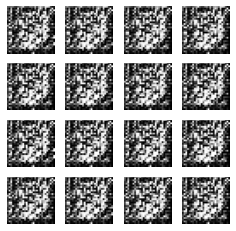

1400 [D loss: 0.000001, acc.: 100.00%] [G loss: 0.000424]


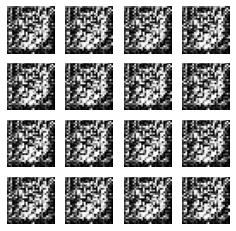

1500 [D loss: 0.000001, acc.: 100.00%] [G loss: 0.000429]


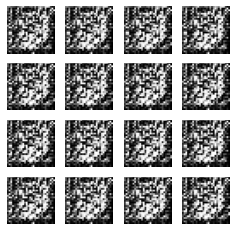

1600 [D loss: 0.000001, acc.: 100.00%] [G loss: 0.000434]


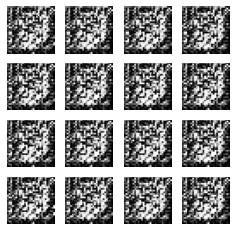

1700 [D loss: 0.000001, acc.: 100.00%] [G loss: 0.000437]


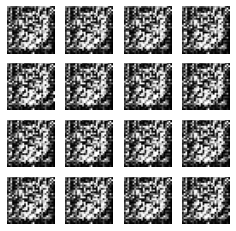

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-b1203fe5c602>", line 6, in <module>
    train(iterations, batch_size, sample_interval)
  File "<ipython-input-11-061c5d1aa908>", line 46, in train
    gen_imgs = generator.predict(z)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py", line 88, in _method_wrapper
    return method(self, *args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py", line 1186, in predict
    model=self)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/data_adapter.py", line 1112, in __init__
    model=model)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/data_adapter.py", line 328, in __init__
    indices_dataset = indices_dataset.map(permutatio

KeyboardInterrupt: ignored

In [13]:
# Set hyperparameters
iterations = 20000
batch_size = 128
sample_interval = 100

# Train the DCGAN for the specified number of iterations
train(iterations, batch_size, sample_interval)